# **NEURAL NETWORK**

## Problem

Write an MNIST classifier that trains to 99% accuracy or above.
You should stop training once you reach that level of accuracy.

Hint: It should succeed in less than 10 epochs.

## Initialize

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from matplotlib import pyplot as plt

In [2]:
# set random seeds
np.random.seed(0)
tf.random.set_seed(0)

# show figures inline
%matplotlib inline

## Dataset

Load the MNIST dataset using `tf.tensorflow_datasets` or `tfds`.


In [3]:
# load MNIST dataset
dataset = tfds.load(name='mnist', batch_size=32, as_supervised=True, shuffle_files=False)

# split into train and test subsets
ds_train, ds_test = dataset['train'], dataset['test']

# process data for iteration
ds_train = ds_train.shuffle(1000).prefetch(1)

**Note**
- The `ds_train` or `ds_test` are iterators.
- At each iteration, it returns tuple `(image, label)`
where `image` and `label` are arrays of length equal to the `batch_size`.
- If `batch_size` is not defined, it returns one `image` and `label` at each iteration.
- The `fit()` and `predict()` functions can directly take these iterators.

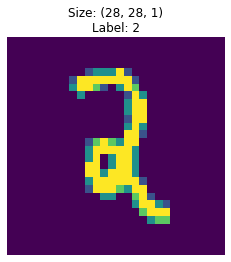

In [4]:
# check one image
(image, label), = ds_train.unbatch().take(1)

# plot
plt.figure()
plt.title(f"Size: {image.shape}\nLabel: {label}")
plt.axis('off')
plt.imshow(image.numpy().squeeze())
plt.show()

**Normalization**
- It allows the NN model to learn all optimal parameters more quickly.

In [5]:
# normalize
ds_train = ds_train.map(lambda image, label: (image/255, label))
ds_test = ds_test.map(lambda image, label: (image/255, label))

## Model

**Note**

- Use `'softmax'` activation function in the output layer since the problem is multi-class classification.
- Use `'sparse_categorical_crossentropy'` loss since labels are of ordinal category.
- Alternatively, you can convert labels to one-hot-encoding, then use `'categorical_crossentropy'` loss.

In [6]:
# input layer
input_tensor = Input(shape=[28, 28, 1])

# hidden layers
x = Flatten()(input_tensor)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)

# output layer with 'softmax' activation function
output_tensor = Dense(10, activation='softmax')(x)

# model
model = tf.keras.Model(input_tensor, output_tensor)

# compile with 'sparse_categorical_crossentropy' loss
model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

# model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


## Callback

- You can use [pre-defined callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks).
- Or, you can define custom callback to have more control over what happens during the training or prediction.
[See more](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback).

**Note**:
- Use `log.get()` to get desired metric to monitor.
- The parameter name in `log.get()` should match the metric defined in `model.compile()`.

In [7]:
class MonitorAccuracy(tf.keras.callbacks.Callback):
    """
    a custom class of callback
    to check accuracy after end of each epoch, and
    to stop training when a certain level of accuracy is reached
    """

    def __init__(self, stop_accuracy=0.99):
        # initiate
        super(MonitorAccuracy, self).__init__()
        self.stop_accuracy = stop_accuracy

    def on_epoch_end(self, epoch, logs=None):
        # at the end of the epoch, print loss and accuracy
        print(f"Epoch {epoch+1} - loss: {logs.get('loss'):.4f} - acc: {logs.get('acc'):.4f}")

        # if accuracy is greater than the given 'stop_accuracy':
        if logs.get('acc') > self.stop_accuracy:
            # print the termination message
            print(f"\nAccuracy reached to {self.stop_accuracy}. So, cancelling training...")
            # stop training
            self.model.stop_training = True


monitor_acc = MonitorAccuracy(0.99)

## Training

In [8]:
# train the model and save the history
hist = model.fit(
    ds_train,
    epochs=10,
    verbose=0,
    callbacks=[monitor_acc]
)

Epoch 1 - loss: 0.2089 - acc: 0.9385
Epoch 2 - loss: 0.0851 - acc: 0.9735
Epoch 3 - loss: 0.0595 - acc: 0.9812
Epoch 4 - loss: 0.0443 - acc: 0.9857
Epoch 5 - loss: 0.0354 - acc: 0.9883
Epoch 6 - loss: 0.0266 - acc: 0.9913

Accuracy reached to 0.99. So, cancelling training...


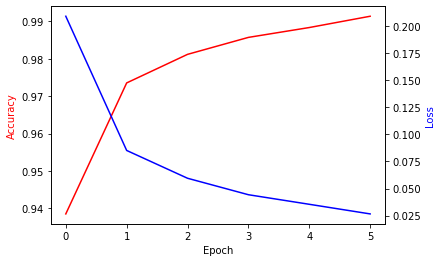

In [9]:
# plot the loss and accuracy
fig = plt.figure()
ax1 = fig.gca()

ax2 = ax1.twinx()
ax1.plot(hist.history['acc'], label='Accuracy', color='r')
ax2.plot(hist.history['loss'], label='Loss', color='b')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='r')
ax2.set_ylabel('Loss', color='b')

plt.show()

## Evauation

In [10]:
# test
y_pred = model.predict(ds_test)
y_pred = np.argmax(y_pred, axis=1)

**Confusion matrix**

In [11]:
# get all labels
# TODO: find more efficient way to get all labels
y_test = []
for x, y in ds_test:
    y_test += list(y)

# confusion matrix
conf_mat = confusion_matrix(y_test, y_pred, normalize='true')

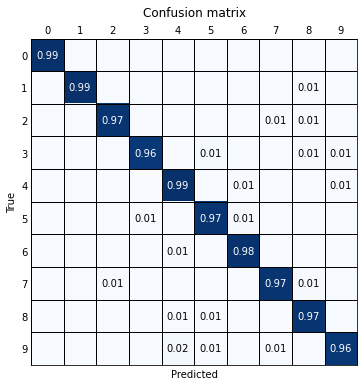

In [12]:
# figure for displaying the confusion matrix
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()

# display the confution matrix
cax = ax.matshow(conf_mat, cmap='Blues')

# show the values
for (i, j), z in np.ndenumerate(conf_mat):
    text_color = 'w' if i == j else 'k'
    if z < 0.005:
        continue
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', c=text_color)

# title and axis labels
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# show class names
labels = list(range(10))
plt.xticks(labels, labels)
plt.yticks(labels, labels)
ax.tick_params(axis='both', which='both', length=0)

# show grid lines
ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-.5, 10, 1), minor=True)
ax.grid(which='minor', color='k', linestyle='-', linewidth=1)

plt.show()

**Other metrics**

In [13]:
# calculate precision, recall, and f1 score
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

In [14]:
# pandas data frame for storing the metrics
df = pd.DataFrame({
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
})

# calculate the mean
df.loc['Mean'] = df.mean()

# display
df.T

,0,1,2,3,4,5,6,7,8,9,Mean
Precision,0.982811,0.991166,0.986261,0.984772,0.960357,0.968785,0.975130,0.980373,0.957533,0.973896,0.976108
Recall,0.991837,0.988546,0.973837,0.960396,0.986762,0.974215,0.982255,0.971790,0.972279,0.961348,0.976326
F1-score,0.987303,0.989854,0.980010,0.972431,0.973380,0.971492,0.978679,0.976063,0.964850,0.967581,0.976164
